# $\nu_{\mu}$ CC inclusive selection

In [1]:
import uproot as uproot
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
plt.style.use('./presentation.mplstyle')

from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

from branches import *
from pandas_helpers import *

In [2]:
PDG = {
    "muon": [13, "muon", 0.105,],
    "proton": [2212, "proton", 0.938272,], 
    "neutron": [2112, "neutron", 0.9395654,], 
    "pizero": [111, "pizero", 0.1349768], 
    "piplus": [211, "piplus", 0.13957039], 
    "piminus": [-211, "piminus", 0.13957039], 
    "argon": [1000180400, "argon", (18*0.938272 + 22*0.9395654)], 
    "gamma": [22, "gamma", 0 ], 
    "lambda": [3122, "lambda", 1.115683], 
    "kaon_p": [321, "kaon_p",  0.493677], 
    "sigma_p": [3222, "sigma_p", 1.18936], 
    "kaon_0": [311, "kaon_0", 0.497648], 
    "sigma_0": [3212, "sigma_0", 1.19246], 
    "lambda_p_c": [4122, "lambda_p_c", 2.28646], 
    "sigma_pp_c": [4222, "sigma_pp_c", 2.45397], 
    "electron": [11, "electron", 0.510998950], 
    "sigma_p_c": [4212, "sigma_p_c", 2.4529],
}

THRESHOLD = {"muon": 0.175, "proton": 0.3, "proton_stub": 0.2, "picharged": 0.07, "pizero":0}

In [3]:
def InFV(data): # cm
    xmin = -199.15 + 10
    ymin = -200. + 10
    zmin = 0.0 + 10
    xmax = 199.15 - 10
    ymax =  200. - 10
    zmax =  500. - 50
    return (data.x > xmin) & (data.x < xmax) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

def InBeam(t):
    return (t > 0.) & (t < 1.800)

def Avg(df, pid, drop_0=True):  # average score of 3 planes, exclude value if 0
    if drop_0:
        df = df.replace(0, np.nan)
    average = df[[("chi2pid", "I0", "chi2_"+pid), ("chi2pid", "I1", "chi2_"+pid), ("chi2pid", "I2", "chi2_"+pid)]].mean(skipna=drop_0, axis=1)
    return average

def Signal(df): # signal definition
    is_fv = InFV(df.nu.position)
    is_numu = (df.nu.pdg == 14)
    is_cc = (df.nu.iscc == 1)
    is_1p0pi = (df.mult_proton_def == 1) & (df.mult_picharged_def == 0) & (df.mult_pizero == 0)
    return is_fv & is_numu & is_cc # & is_1p0pi

In [4]:
filename = "/exp/sbnd/data/users/munjung/SBND/2023B/cnnid/cnnid.flat.caf.root"
events = uproot.open(filename+":recTree")

In [5]:
# MC truth
nudf = loadbranches(events, mc_branches)
nudf = nudf.rec.mc

nuprimdf = loadbranches(events, mc_prim_branches)
nuprimdf = nuprimdf.rec.mc.nu
nuprimdf[("prim","totp","")] = np.sqrt((nuprimdf.prim.startp.x)**2+(nuprimdf.prim.startp.y)**2+(nuprimdf.prim.startp.z)**2) # |momentum| branch

# primary track multiplicity
mult_muon = (nuprimdf.prim.pdg == 13).groupby(level=[0,1]).sum()
mult_muon_def = ((nuprimdf.prim.pdg == 13) & (nuprimdf.prim.totp > THRESHOLD["muon"])).groupby(level=[0,1]).sum()
mult_proton = (nuprimdf.prim.pdg == 2212).groupby(level=[0,1]).sum()
mult_proton_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton"])).groupby(level=[0,1]).sum()
mult_proton_stub_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton_stub"])).groupby(level=[0,1]).sum()
mult_picharged = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_picharged_def = ((np.abs(nuprimdf.prim.pdg) == 211) & (nuprimdf.prim.totp > THRESHOLD["picharged"])).groupby(level=[0,1]).sum()
mult_pizero = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_pizero_def = ((np.abs(nuprimdf.prim.pdg) == 111) & (nuprimdf.prim.totp > THRESHOLD["pizero"])).groupby(level=[0,1]).sum()
mult_electron = (nuprimdf.prim.pdg == 11).groupby(level=[0,1]).sum()
mult_photon = (nuprimdf.prim.pdg == 22).groupby(level=[0,1]).sum()
nudf['mult_muon'] = mult_muon
nudf['mult_muon_def'] = mult_muon_def
nudf['mult_proton'] = mult_proton
nudf['mult_proton_def'] = mult_proton_def
nudf['mult_proton_stub_def'] = mult_proton_stub_def
nudf['mult_picharged'] = mult_picharged
nudf['mult_picharged_def'] = mult_picharged_def
nudf['mult_pizero'] = mult_pizero
nudf['mult_pizero_def'] = mult_pizero_def
nudf['mult_electron'] = mult_electron
nudf['mult_photon'] = mult_photon

In [6]:
# truth match
slcdf = loadbranches(events, slc_branches)
slcdf = slcdf.rec

slcdf.loc[np.invert(slcdf[("slc","tmatch","eff")] > 0.5) & (slcdf[("slc","tmatch","idx")] >= 0), ("slc","tmatch","idx")] = np.nan
slcdf["tmatch_index"] = slcdf[("slc", "tmatch", "idx")]
matchdf = pd.merge(slcdf.reset_index(), 
                 nudf.reset_index(),
                 left_on=[("entry", "",""), ("slc","tmatch", "idx")], # entry index -> neutrino index
                 right_on=[("entry", "",""), ("rec.mc.nu..index", "","")], 
                 how="left", # Keep every slc
                 ) 
matchdf = matchdf.set_index(["entry", "rec.slc..index"], verify_integrity=True)

# reco pfps
pfptrkdf = loadbranches(events, pfp_trk_branches)
pfptrkdf = pfptrkdf.rec.slc.reco.pfp
pfptrkchi2df = loadbranches(events, pfp_trk_chi2_branches)
pfptrkchi2df = pfptrkchi2df.rec.slc.reco.pfp.trk
pfptrkdf = pfptrkdf.join(pfptrkchi2df)

pfptruthdf = loadbranches(events, pfp_trk_mc_branches)
pfptruthdf = pfptruthdf.rec.slc.reco.pfp.trk.truth
pfpdf = pd.merge(pfptrkdf, pfptruthdf, left_index=True, right_index=True, how="inner")

pandoradf = loadbranches(events, pandora_branches)
pandoradf = pandoradf.rec.slc
cnniddf = loadbranches(events, cnn_branches)
cnniddf = cnniddf.rec.slc.reco
scoresdf = pd.merge(pandoradf, cnniddf, left_index=True, right_index=True, how="inner")
pfpdf = pd.merge(pfpdf, scoresdf, left_index=True, right_index=True, how="inner")

# merge all
masterdf = pd.merge(matchdf, pfpdf, left_index=True, right_index=True, how="inner")

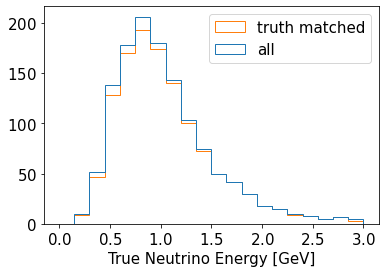

In [7]:
# truth match efficiency
nu_idx = matchdf.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()
nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]
nudf_tmatched = nudf.loc[nu_idx]
var = [nudf[Signal(nudf)].nu.E, nudf_tmatched[Signal(nudf_tmatched)].nu.E]
plt.hist(var, bins=np.linspace(0,3,21), histtype="step", label=["all", "truth matched"])
plt.xlabel("True Neutrino Energy [GeV]")
plt.legend()
plt.show();

## Event Selection

In [8]:
# reco vertex in FV
cut = InFV(masterdf.slc.vertex)
df_vertexcut = masterdf[cut]

In [9]:
# cosmic rejection
cut_nuscore = (df_vertexcut.slc.nu_score.squeeze() > 0.4)
cut_fmatch = ((df_vertexcut.slc.fmatch.score < 7.0) & (InBeam(df_vertexcut.slc.fmatch.time)))
df_cosmiccut = df_vertexcut[cut_nuscore & cut_fmatch]

In [10]:
# 1 muon
MUCUT_MUSCORE_THRES = 30
MUCUT_PSCORE_THRES = 60
MUCUT_LEN_THRES = 50
cut_pidscore = (Avg(df_cosmiccut, "muon", drop_0=True) < MUCUT_MUSCORE_THRES) & (Avg(df_cosmiccut, "proton", drop_0=True) > MUCUT_PSCORE_THRES)
cut_len = (df_cosmiccut.trk.len > MUCUT_LEN_THRES)
primary_muons = df_cosmiccut[cut_pidscore & cut_len]
primary_muons = primary_muons.sort_values(["entry", "rec.slc..index", ("trk","len","")], ascending=[True, True, False])
leading_muon = primary_muons.groupby(["entry", "rec.slc..index"]).head(1) 

slc_idx_1mu = leading_muon.reset_index().set_index(["entry", "rec.slc..index"]).index.unique()
df_1mucut = df_cosmiccut.reset_index().set_index(["entry", "rec.slc..index"]).loc[slc_idx_1mu]
df_1mucut = df_1mucut.reset_index().set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index"], verify_integrity=True)

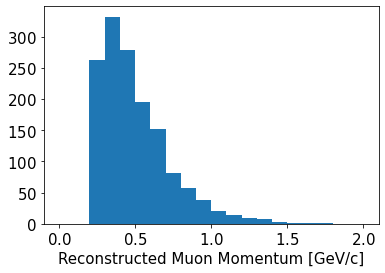

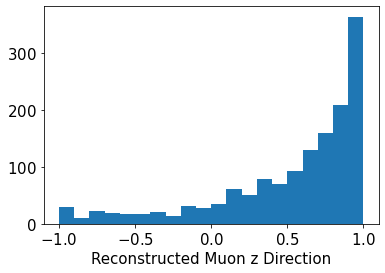

In [11]:
var = leading_muon.trk.rangeP.p_muon
plt.hist(var, bins=np.linspace(0,2,21))
plt.xlabel("Reconstructed Muon Momentum [GeV/c]")
plt.show();

var = leading_muon.trk.dir.z
plt.hist(var, bins=np.linspace(-1,1,21))
plt.xlabel("Reconstructed Muon z Direction")
plt.show();

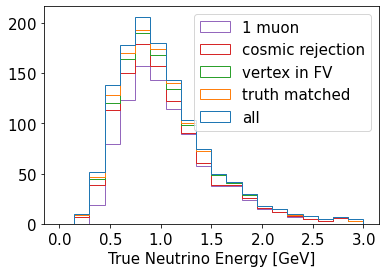

In [12]:
# efficiency
nu_idx = df_vertexcut.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()
nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]
nudf_vertexcut = nudf.loc[nu_idx]

nu_idx = df_cosmiccut.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()
nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]
nudf_cosmiccut = nudf.loc[nu_idx]

nu_idx = df_1mucut.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()
nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]
nudf_1mucut = nudf.loc[nu_idx]

var = [nudf[Signal(nudf)].nu.E, 
       nudf_tmatched[Signal(nudf_tmatched)].nu.E,
       nudf_vertexcut[Signal(nudf_vertexcut)].nu.E,
       nudf_cosmiccut[Signal(nudf_cosmiccut)].nu.E,
       nudf_1mucut[Signal(nudf_1mucut)].nu.E]
n, bins, _ = plt.hist(var, bins=np.linspace(0,3,21), histtype="step", 
                      label=["all", "truth matched", "vertex in FV", "cosmic rejection", "1 muon"])
plt.xlabel("True Neutrino Energy [GeV]")
plt.legend()
plt.show();

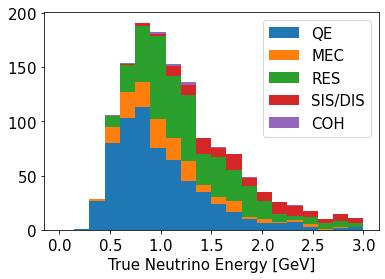

In [13]:
# selected true neutrino events interaction breakdown
mode_list = [0, 10, 1, 2, 3]
mode_labels = ['QE', 'MEC', 'RES', 'SIS/DIS', 'COH']
var = [nudf_1mucut[nudf_1mucut.nu.genie_mode == mode].nu.E for mode in mode_list]
plt.hist(var, bins=np.linspace(0,3,21), stacked=True, label=mode_labels)
plt.xlabel("True Neutrino Energy [GeV]")
plt.legend()
plt.show();